# Imports and loading entire Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

# Load the full training data
# Ensure the path '../data/train.csv' is correct for your environment
full_df = pd.read_csv('../data/train.csv')

print(f"Full Dataset Shape: {full_df.shape}")

Full Dataset Shape: (59611, 24)


# functions for pre processing

In [2]:
def clean_data(df):
    # 1. Drop Duplicates
    df = df.drop_duplicates()
    
    # 2. Anomaly Removal
    # Keep only founders 18 or older
    df = df[df['founder_age'] >= 18]
    
    # Keep only valid tenures (started at age 16+)
    df = df[(df['founder_age'] - df['years_with_startup']) >= 16]
    
    # 3. Missing Value Imputation
    # Numerical: Median (robust to outliers)
    num_cols = ['monthly_revenue_generated', 'years_since_founding', 'num_dependents']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
        
    # Categorical: Treat "Missing" as "Unknown" for psychological surveys
    df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna('Unknown')
    df['venture_satisfaction'] = df['venture_satisfaction'].fillna('Unknown')
    
    # For other structural columns, use Mode
    df['team_size_category'] = df['team_size_category'].fillna(df['team_size_category'].mode()[0])
    
    # 4. Feature Engineering (Simplification)
    df['start_age'] = df['founder_age'] - df['years_with_startup']
    
    # 5. Encoding Target
    target_map = {'Stayed': 0, 'Left': 1}
    df['target'] = df['retention_status'].map(target_map)
    
    # Drop unused columns
    cols_to_drop = ['founder_id', 'retention_status']
    df = df.drop(columns=cols_to_drop)
    
    return df

def encode_and_split_mini(df):
    # --- 1. ORDINAL ENCODING ---
    rating_map = {'Unknown': 0, 'Low': 1, 'Poor': 1, 'Below Average': 2, 
                  'Fair': 3, 'Medium': 3, 'Average': 3, 
                  'Good': 4, 'High': 4, 'Very High': 5, 'Excellent': 5}
    
    ord_cols = ['work_life_balance_rating', 'venture_satisfaction', 
                'startup_performance_rating', 'startup_reputation', 'founder_visibility']
    
    for col in ord_cols:
        df[col] = df[col].map(rating_map).fillna(0)

    # Map Binary Columns
    binary_map = {'No': 0, 'Yes': 1}
    bin_cols = ['working_overtime', 'remote_operations', 'innovation_support', 'leadership_scope']
    for col in bin_cols:
        df[col] = df[col].map(binary_map)

    # Map Startup Stage
    stage_map = {'Entry': 1, 'Mid': 2, 'Senior': 3, 'Growth': 3, 'Established': 4}
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(1)

    # --- 2. ONE-HOT ENCODING ---
    df = pd.get_dummies(df, columns=['founder_gender', 'founder_role', 
                                     'education_background', 'personal_status', 
                                     'team_size_category'], drop_first=True)

    # --- 3. SEPARATE X and y ---
    X = df.drop('target', axis=1)
    y = df['target']
    
    # --- 4. INTERNAL SPLIT (80/20 of the Mini Data) ---
    # This splits the Mini Data into Training (80%) and Evaluation (20%) sets
    X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # --- 5. SCALING ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_mini)
    # Important: Transform test set using the scaler fitted on training set
    X_test_scaled = scaler.transform(X_test_mini)
    
    # Convert back to DataFrame for readability
    X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)
    
    return X_train_final, X_test_final, y_train_mini, y_test_mini

In [3]:
# 1. Clean the Mini Data
full_df_clean = clean_data(full_df)
print(f"Cleaned Data Shape: {full_df_clean.shape}")

# 2. Encode and Split (80/20 split inside here)
X_train, X_test, y_train, y_test = encode_and_split_mini(full_df_clean)

print(f"Training Set (80%): {X_train.shape}")
print(f"Testing Set (20%):  {X_test.shape}")

Cleaned Data Shape: (40543, 24)
Training Set (80%): (32434, 31)
Testing Set (20%):  (8109, 31)


# SVM Classifier

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score

print("Training Final SVM on full Data (80%) with Best Parameters...")

# 1. Initialize SVM with the specific parameters found
best_params_svm = {
    'C': 0.17066305219717406, 
    'class_weight': 'balanced', 
    'decision_function_shape': 'ovo', 
    'degree': 4, 
    'gamma': 'scale', 
    'kernel': 'sigmoid', 
    'shrinking': False,
    'random_state': 42
}

final_svm_mini = SVC(**best_params_svm)

# 2. Train on the 80% Split of Mini Data
final_svm_mini.fit(X_train, y_train)

# 3. Predict on the remaining 20% Split of Mini Data
y_pred_svm_final = final_svm_mini.predict(X_test)

# 4. Evaluate Performance
svm_acc = accuracy_score(y_test, y_pred_svm_final)
svm_f1 = f1_score(y_test, y_pred_svm_final, average='macro')

print(f"\nFinal SVM Accuracy : {svm_acc:.2%}")
print(f"Final SVM F1 Macro Score: {svm_f1:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_final, target_names=['Stayed', 'Left']))

Training Final SVM on full Data (80%) with Best Parameters...

Final SVM Accuracy : 70.97%
Final SVM F1 Macro Score: 70.95%

Classification Report:
              precision    recall  f1-score   support

      Stayed       0.73      0.70      0.72      4235
        Left       0.69      0.72      0.70      3874

    accuracy                           0.71      8109
   macro avg       0.71      0.71      0.71      8109
weighted avg       0.71      0.71      0.71      8109



# NN Classifier

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

print("Training Final Neural Network on Mini Data (80%) with Best Parameters...")

# 1. Initialize MLP with the specific parameters found
best_params_mlp = {
    'activation': 'relu',
    'alpha': 0.0011208547084229376,
    'hidden_layer_sizes': (30,),
    'learning_rate_init': 0.00012397420340784152,
    'solver': 'adam',
    'max_iter': 1000, # Ensure enough iterations for convergence
    'random_state': 42
}

final_mlp_mini = MLPClassifier(**best_params_mlp)

# 2. Train on the 80% Split of Mini Data
final_mlp_mini.fit(X_train, y_train)

# 3. Predict on the remaining 20% Split of Mini Data
y_pred_mlp_final = final_mlp_mini.predict(X_test)

# 4. Evaluate Performance
mlp_acc = accuracy_score(y_test, y_pred_mlp_final)
mlp_f1 = f1_score(y_test, y_pred_mlp_final, average='macro')

print(f"\nFinal Neural Network Accuracy (Mini Data Test Split): {mlp_acc:.2%}")
print(f"Final Neural Network F1 Macro Score: {mlp_f1:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp_final, target_names=['Stayed', 'Left']))

Training Final Neural Network on Mini Data (80%) with Best Parameters...

Final Neural Network Accuracy (Mini Data Test Split): 73.40%
Final Neural Network F1 Macro Score: 73.36%

Classification Report:
              precision    recall  f1-score   support

      Stayed       0.75      0.74      0.74      4235
        Left       0.72      0.73      0.72      3874

    accuracy                           0.73      8109
   macro avg       0.73      0.73      0.73      8109
weighted avg       0.73      0.73      0.73      8109



# Comparison of Models

MODEL COMPARISON SUMMARY
         Model  Accuracy  F1 Macro Score
           SVM  0.709705        0.709534
Neural Network  0.733999        0.733584

🏆 BEST MODEL: Neural Network
   Accuracy: 73.40%
   F1 Macro Score: 73.36%


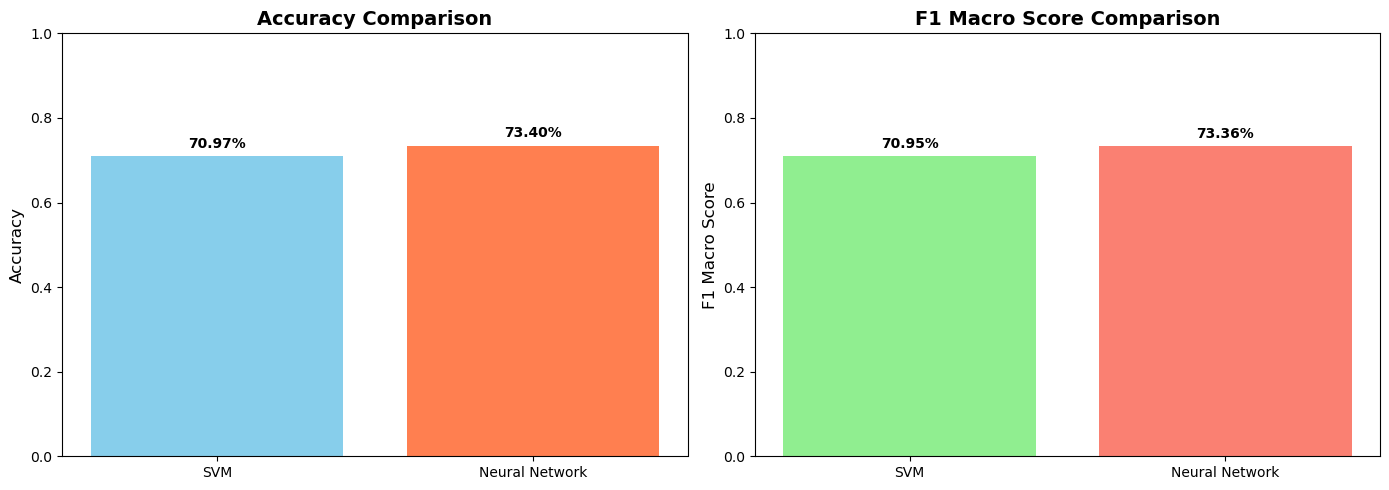


📊 PERFORMANCE DIFFERENCE:
   Accuracy Difference: 2.43%
   F1 Score Difference: 2.41%


In [6]:
import matplotlib.pyplot as plt

# Create comparison dictionary
comparison_data = {
    'Model': ['SVM', 'Neural Network'],
    'Accuracy': [svm_acc, mlp_acc],
    'F1 Macro Score': [svm_f1, mlp_f1]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Determine best model
if svm_f1 > mlp_f1:
    best_model = "SVM"
    best_f1 = svm_f1
    best_acc = svm_acc
else:
    best_model = "Neural Network"
    best_f1 = mlp_f1
    best_acc = mlp_acc

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Accuracy: {best_acc:.2%}")
print(f"   F1 Macro Score: {best_f1:.2%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['skyblue', 'coral'])
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Plot 2: F1 Macro Score Comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1 Macro Score'], color=['lightgreen', 'salmon'])
axes[1].set_ylabel('F1 Macro Score', fontsize=12)
axes[1].set_title('F1 Macro Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, v in enumerate(comparison_df['F1 Macro Score']):
    axes[1].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Performance difference
acc_diff = abs(svm_acc - mlp_acc)
f1_diff = abs(svm_f1 - mlp_f1)

print(f"\n📊 PERFORMANCE DIFFERENCE:")
print(f"   Accuracy Difference: {acc_diff:.2%}")
print(f"   F1 Score Difference: {f1_diff:.2%}")